## CODE NOTES
Goal: To test the k-fold splitting that performance is not biased across splits
Steps:
- Load RFR raw dataset, which is pre-split and pre-transform
- Split RFR dataset with new split dict
- Transform features by fitting scaler on train, applying to other sets
- Run CV and compare metrics
- Hope to see more balanced metrics :)

# Notebook Setup

In [1]:
#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
#MY_HOME_ABS_PATH = "/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling"
MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"

## Import Modules

In [3]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import sys
import math
import json
import time
import pandas as pd
import numpy as np
from calendar import monthrange
from datetime import datetime
from io import BytesIO
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Define Local File System Constants

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
preproc_objects_dir = root_dir + os.sep + 'code' + os.sep + 'src' + os.sep + 'preprocessing' + os.sep + 'preproc_objects'

az_cred_file = cred_dir + os.sep + 'azblobcred.json'
model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'

## Load Raw Dataset from RFR v2

In [5]:
# Define dataset
container = "all-sites-data"
raw_blob_name = 'rfr-full_2010_2015_v_mvp-v2-knn_raw.parquet'

In [6]:
# Load splits from Azure
azStorageClient = AzStorageClient(az_cred_file)

raw_fs = azStorageClient.downloadBlob2Stream(container, raw_blob_name)
full_raw_df = pd.read_parquet(raw_fs, engine='pyarrow')

## Redefine Transformation Function

In [7]:
def add_dummy_var(df,categorical_cols):
    dummy_df = pd.get_dummies(df[categorical_cols])
    df = df.drop(columns=categorical_cols)
    df = pd.concat([df, dummy_df], axis=1)
    return df

def data_transform_forCV(full_raw_df, train_site_id, val_site_id, test_site_id,
                         categorical_cols, realNum_cols, cat_encode_type='label'):
    # Encode the categorical columns
    if cat_encode_type == 'label':
        full_raw_df[categorical_cols] = full_raw_df[categorical_cols].apply(LabelEncoder().fit_transform)
    elif cat_encode_type == 'dummy':
        full_raw_df = add_dummy_var(full_raw_df,categorical_cols)

    train_df = full_raw_df.loc[full_raw_df['site_id'].isin(train_site_id), ].copy()
    val_df = full_raw_df.loc[full_raw_df['site_id'].isin(val_site_id), ].copy()
    test_df  = full_raw_df.loc[full_raw_df['site_id'].isin(test_site_id), ].copy()
    print(f"Number of sites in df: {len(full_raw_df['site_id'].unique())}")

    print(f"Data size after encoding: {train_df.shape}")  
    print(f"Data size after encoding: {val_df.shape}")
    print(f"Data size after encoding: {test_df.shape}")

    print(f"Train Sites: {train_df['site_id'].unique()}")
    print(f"Val Sites: {val_df['site_id'].unique()}")
    print(f"Test Sites: {test_df['site_id'].unique()}")

    # Normalize data
    print(f"Normalizing real features ({len(realNum_cols)})")
    scaler = StandardScaler().fit(train_df[realNum_cols])
    train_df.loc[:,realNum_cols] = scaler.transform(train_df[realNum_cols])
    val_df.loc[:,realNum_cols] = scaler.transform(val_df[realNum_cols])
    test_df.loc[:,realNum_cols] = scaler.transform(test_df[realNum_cols])

    print(f"Train data size: {train_df.shape}.")
    print(f"Val data size: {val_df.shape}.")
    print(f"Test data size: {test_df.shape}.")  
    train_df.reset_index(inplace=True, drop=True)
    val_df.reset_index(inplace=True, drop=True)
    test_df.reset_index(inplace=True, drop=True)

    # Drop unnecessary features
    X_train, y_train, X_val, y_val, X_test, y_test = drop_unneeded_var(train_df, val_df, test_df)
  
    return X_train, y_train, X_val, y_val, X_test, y_test

# Prep x, y dataset for train
def drop_unneeded_var(train_df, val_df, test_df):
    X_train = train_df.drop([target_variable] + drop_cols, axis=1)
    y_train = train_df[target_variable]
    X_val = val_df.drop([target_variable] + drop_cols, axis=1)
    y_val = val_df[target_variable]
    X_test = test_df.drop([target_variable] + drop_cols, axis=1)
    y_test = test_df[target_variable]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# Prep x, y dataset for train
target_variable = 'GPP_NT_VUT_REF'
drop_cols = ['site_id', 'timestep_idx_local', 'timestep_idx_global', 'index', 
             'datetime','gap_flag_hour', 'gap_flag_month', 'date']
            #  'c3c4', 'c4_percent']# add date

msc_features = ['TA_ERA', 'SW_IN_ERA', 'P_ERA', 'EVI', 'NDVI', 'NIRv', 'b4']
categorical_cols = ['koppen_sub', 'koppen_main', 'month', 'day', 'hour', 'MODIS_LC',
                   'c3c4', 'MODIS_PFT', 'MODIS_IGBP', 'hemisphere_NS', 'lat_band']
realNum_cols = ['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 
                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
                'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
                'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai',
                'LST_Day', 'LST_Night', 'prcp', 'prcp-lag3'] + \
                [f"{feat}{ext}" for feat in msc_features for ext in ["_szn_mean", "_amp_msc", "_min_msc"]]

## Load New Split Dict (which uses clustering on IGBP, GPP_mean, GPP_variance)

In [9]:
site_splits = joblib.load(os.path.join(preproc_objects_dir, 'clustered_stratified_splits_k5.joblib'))
print(site_splits.keys())

dict_keys(['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'VAL_INDEX', 'TEST_INDEX', 'NUM_FOLDS'])


## Create CV Dataset

In [10]:
group1_id, group2_id, group3_id, group4_id, test_site_id = \
    site_splits['fold_1'],  site_splits['fold_2'],  site_splits['fold_3'],  site_splits['fold_4'],  site_splits['fold_5']

In [11]:
# Assign data to 4 groups
cv1_val_site_list = group1_id
cv1_train_site_list = group2_id + group3_id +group4_id

cv2_val_site_list = group2_id
cv2_train_site_list = group1_id + group3_id +group4_id

cv3_val_site_list = group3_id
cv3_train_site_list = group2_id + group1_id +group4_id

cv4_val_site_list = group4_id
cv4_train_site_list = group2_id + group3_id +group1_id

## Data Transformation

In [12]:
print("--CV1------------------------------------------------------------------------------")
X_train_cv1, y_train_cv1, X_val_cv1, y_val_cv1, X_test_cv1, y_test_cv1 = data_transform_forCV(full_raw_df,
                                                                                              cv1_train_site_list,
                                                                                              cv1_val_site_list,
                                                                                              test_site_id,
                                                                                              categorical_cols, 
                                                                                              realNum_cols,
                                                                                              cat_encode_type='dummy')

print("--CV2------------------------------------------------------------------------------")
X_train_cv2, y_train_cv2, X_val_cv2, y_val_cv2, X_test_cv2, y_test_cv2 = data_transform_forCV(full_raw_df,
                                                                                              cv2_train_site_list,
                                                                                              cv2_val_site_list,
                                                                                              test_site_id,
                                                                                              categorical_cols, 
                                                                                              realNum_cols,
                                                                                              cat_encode_type='dummy')
print("--CV3------------------------------------------------------------------------------")
X_train_cv3, y_train_cv3, X_val_cv3, y_val_cv3, X_test_cv3, y_test_cv3 = data_transform_forCV(full_raw_df,
                                                                                              cv3_train_site_list,
                                                                                              cv3_val_site_list,
                                                                                              test_site_id,
                                                                                              categorical_cols, 
                                                                                              realNum_cols,
                                                                                              cat_encode_type='dummy')
print("--CV4------------------------------------------------------------------------------")
X_train_cv4, y_train_cv4, X_val_cv4, y_val_cv4, X_test_cv4, y_test_cv4 = data_transform_forCV(full_raw_df,
                                                                                              cv4_train_site_list,
                                                                                              cv4_val_site_list,
                                                                                              test_site_id,
                                                                                              categorical_cols, 
                                                                                              realNum_cols,
                                                                                              cat_encode_type='dummy')


--CV1------------------------------------------------------------------------------
Number of sites in df: 128
Data size after encoding: (2926464, 103)
Data size after encoding: (803328, 103)
Data size after encoding: (847896, 103)
Train Sites: ['AT-Neu' 'AU-ASM' 'AU-DaS' 'AU-Emr' 'AU-Gin' 'AU-How' 'AU-RDF' 'AU-Stp'
 'AU-TTE' 'BE-Bra' 'BE-Vie' 'CA-Ca1' 'CA-Ca2' 'CA-Gro' 'CA-TP3' 'CA-TP4'
 'CH-Dav' 'CH-Fru' 'CH-Lae' 'CH-Oe2' 'CZ-BK2' 'CZ-RAJ' 'CZ-Stn' 'CZ-wet'
 'DE-HoH' 'DE-Hte' 'DE-Lnf' 'DE-RuR' 'DE-SfN' 'DE-Spw' 'DE-Tha' 'ES-LJu'
 'FI-Hyy' 'FI-Let' 'FR-Aur' 'FR-Bil' 'FR-FBn' 'FR-Fon' 'FR-Hes' 'FR-Lam'
 'FR-Pue' 'GF-Guy' 'IT-BCi' 'IT-CA1' 'IT-CA2' 'IT-Lav' 'IT-MBo' 'IT-Noe'
 'IT-Ren' 'IT-Ro2' 'IT-SR2' 'NL-Loo' 'RU-Fyo' 'SE-Deg' 'SE-Htm' 'SE-Nor'
 'US-ARM' 'US-Bar' 'US-Ho1' 'US-IB2' 'US-KFS' 'US-Me6' 'US-Mpj' 'US-NR1'
 'US-Prr' 'US-Ro1' 'US-Rws' 'US-SRG' 'US-Seg' 'US-Ses' 'US-Syv' 'US-Ton'
 'US-Tw4' 'US-Twt' 'US-UMd' 'US-Var' 'US-Whs']
Val Sites: ['AR-SLu' 'AU-Cum' 'AU-DaP' 'AU-Rig' 'BE

## Cross Validation on RFR Full

In [13]:
# Using best params from the tuned model in V1
best_params = {}
best_params['n_estimators'] = 50
best_params['max_depth'] = 10
best_params['max_features'] = 'sqrt'

# model1
cv_model1 = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
cv_model1.fit(X_train_cv1, list(y_train_cv1))
print("Finished model 1")

# model2
cv_model2 = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
cv_model2.fit(X_train_cv2, y_train_cv2)
print("Finished model 2")

# model3
cv_model3 = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
cv_model3.fit(X_train_cv3, y_train_cv3)
print("Finished model 3")

# model4
cv_model4 = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
cv_model4.fit(X_train_cv4, y_train_cv4)
print("Finished model 4")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:   15.6s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.9s finished


Finished model 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:   13.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.4s finished


Finished model 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:   14.8s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.7s finished


Finished model 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:   14.6s remaining:    4.6s


Finished model 4


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.5s finished


## Evaluate RFR on Val Set

In [14]:
# Evaluate predictions - VAL
def eval_metrics(model, X_val, y_val):
  y_pred = model.predict(X_val)
  
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  mae = mean_absolute_error(y_val, y_pred)
  r2 = r2_score(y_val, y_pred)
  print("")
  print(f'Val RMSE: {rmse}, "Val MAE: {mae}, Val R2/NSE: {r2}')
  return [rmse, mae, r2]

In [15]:
cv1_result = eval_metrics(cv_model1, X_val_cv1, y_val_cv1)
cv2_result = eval_metrics(cv_model2, X_val_cv2, y_val_cv2)
cv3_result = eval_metrics(cv_model3, X_val_cv3, y_val_cv3)
cv4_result = eval_metrics(cv_model4, X_val_cv4, y_val_cv4)

cv_result = [["RMSE", "MAE", "R2"]]
cv_result_df = pd.DataFrame([cv1_result, cv2_result, 
                             cv3_result, cv4_result],columns=cv_result)
cv_result_df

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.1s finished



Val RMSE: 4.067724938134661, "Val MAE: 2.25497921166248, Val R2/NSE: 0.6816227024985512


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.2s finished



Val RMSE: 4.021807827269301, "Val MAE: 2.326340902585285, Val R2/NSE: 0.6765842011361605


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.1s finished



Val RMSE: 4.030910562416023, "Val MAE: 2.2489566804636523, Val R2/NSE: 0.6578845202968275

Val RMSE: 4.168802934232785, "Val MAE: 2.368284808640706, Val R2/NSE: 0.635173112825214


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.1s finished


,RMSE,MAE,R2
0,4.06772,2.25498,0.68162
1,4.02181,2.32634,0.67658
2,4.03091,2.24896,0.65788
3,4.16880,2.36828,0.63517


In [16]:
cv_result_df.mean()

RMSE   4.07231
MAE    2.29964
R2     0.66282
dtype: float64

## Compare Feature Importances

In [17]:
def feature_importance(model, model_name, columns, fig_num, fig, ax):
    # get the feature importances
  importances = pd.Series(model.feature_importances_, index=columns)#.sort_values(ascending=False)
  # Visualize
  importances_sorted = importances.sort_values(ascending=True)[-30:]

  ax[fig_num].barh(importances_sorted.index, importances_sorted.values)
  ax[fig_num].set_title(model_name + '  Feature Importances')
  ax[fig_num].set_xlabel('Importance')
  ax[fig_num].set_ylabel('Feature')
  return importances

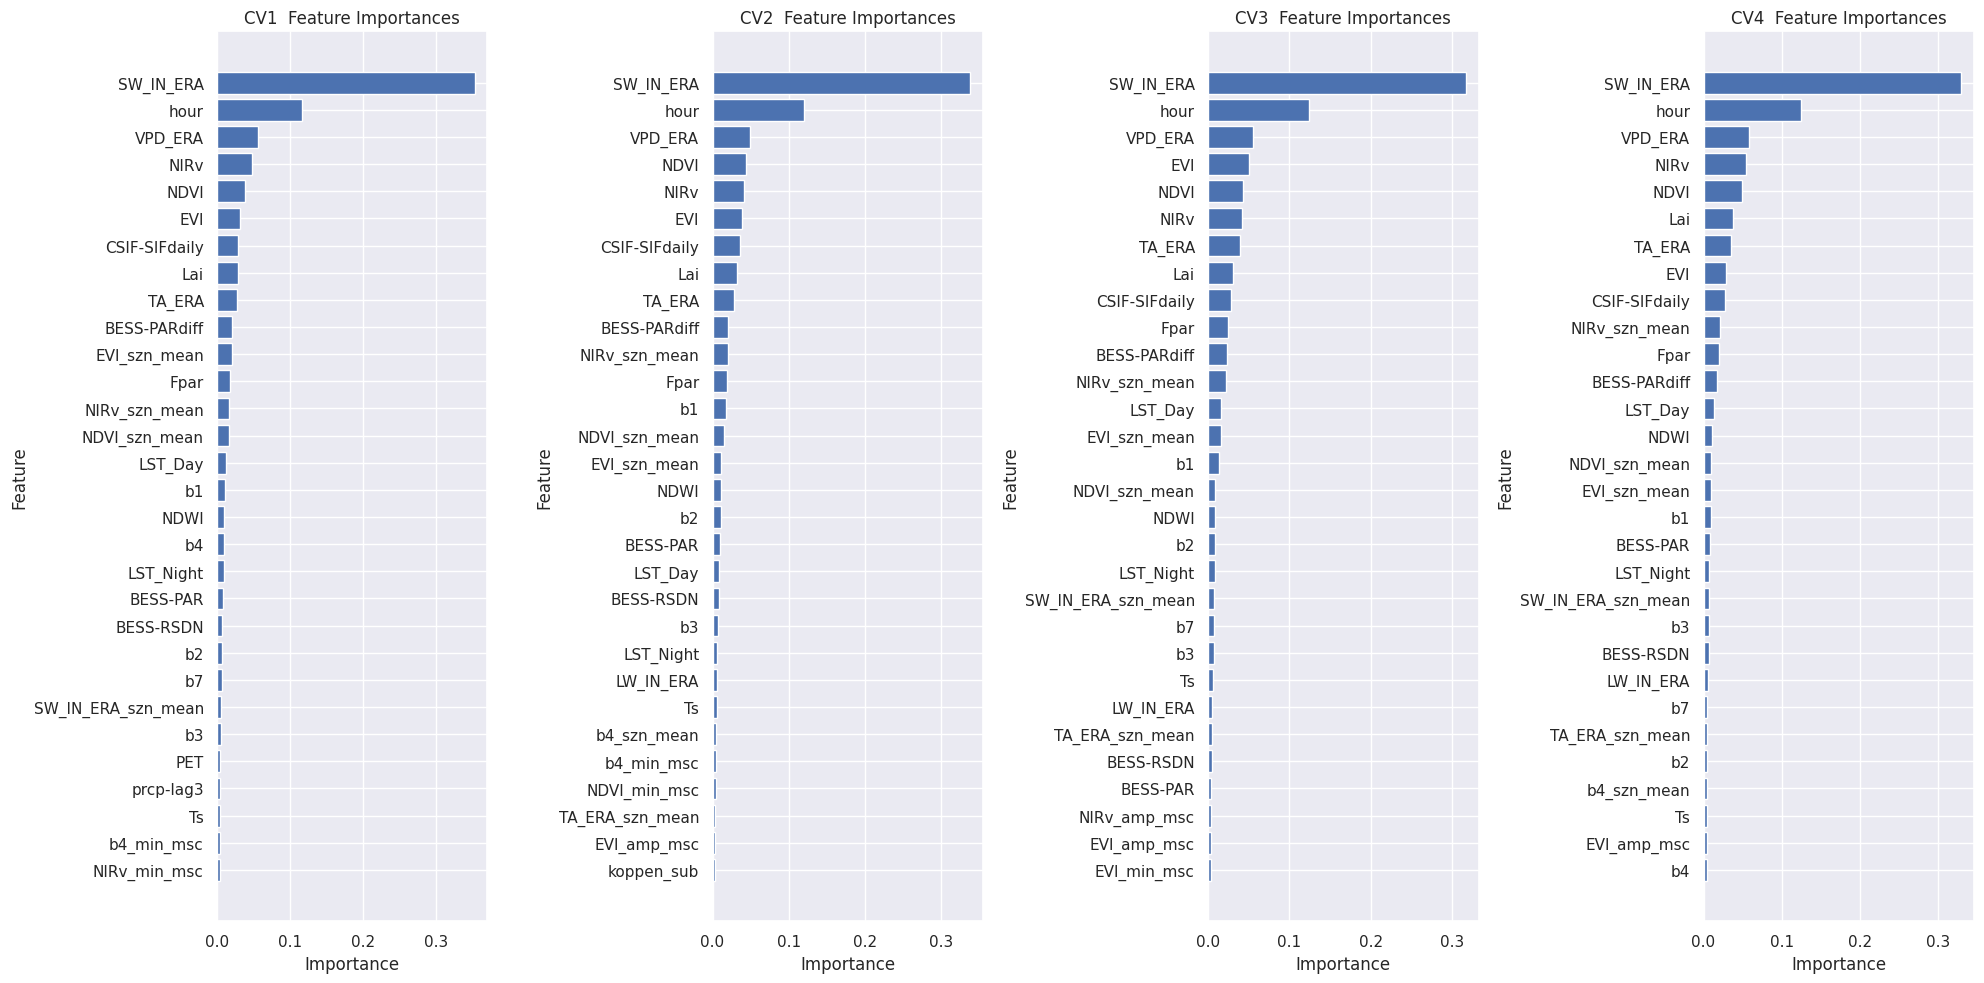

In [18]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,10), })
fig, ax = plt.subplots(1, 4, figsize=(20,10))

cv1_importances = feature_importance(cv_model1, "CV1", X_test_cv1.columns, 0, fig, ax)
cv2_importances = feature_importance(cv_model2, "CV2", X_test_cv1.columns, 1, fig, ax)
cv3_importances = feature_importance(cv_model3, "CV3", X_test_cv1.columns, 2, fig, ax)
cv4_importances = feature_importance(cv_model4, "CV4", X_test_cv1.columns, 3, fig, ax)
fig.tight_layout()
plt.show()
